In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
plot_dir = "/home/llr/ilc/shi/code/Energy-Reco/Figures"
plot_conf="SiThickness"
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
def clean_number(x):
    s = f"{x:g}"          # g 格式自动去掉不必要的小数
    return s
figSize = (8, 6)
axhline_lr=1.5
# Read Data
Config = ("SumE", "NHits","RecoE_MLP")
Legend = ("SumE", "NHits", "MLP")
TotalLayer = 60
SamplingLayer = 30
Si=(0.15,0.30,0.45,0.60,0.75)  # mm
threshold = 0.5
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'cyan', 'magenta']

# Storage
particleEnergy = []
meanGamma = []
meanGammaErr = []
peakGamma = []
peakGammaErr = []
resGamma = []
resGammaErr = []

for SiThickness in Si:
    dataPath = f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si{SiThickness:.2f}mm_layer{SamplingLayer}_in{TotalLayer}/Reco_Results"
    particleEnergy_thr = []
    meanGamma_thr = []
    meanGammaErr_thr = []
    peakGamma_thr = []
    peakGammaErr_thr = []
    resGamma_thr = []
    resGammaErr_thr = []

    for config in Config:
        fileName = os.path.join(dataPath, f"{config}_Fit_Threshold{threshold}.csv")
        if not os.path.exists(fileName):
            print(f"Warning: file not found: {fileName}")
            continue

        df = pd.read_csv(fileName)

        particleEnergy_thr.append(df["ParticleEnergy"].to_numpy())
        meanGamma_thr.append(df["Mean_Gamma"].to_numpy())
        meanGammaErr_thr.append(df["Mean_Gamma_Error"].to_numpy())
        peakGamma_thr.append(df["Peak_Gamma"].to_numpy())
        peakGammaErr_thr.append(df["Peak_Gamma_Error"].to_numpy())
        resGamma_thr.append(df["Res_Gamma"].to_numpy())
        resGammaErr_thr.append(df["Res_Gamma_Error"].to_numpy())

        print(f"Loaded {fileName}")

    particleEnergy.append(particleEnergy_thr)
    meanGamma.append(meanGamma_thr)
    meanGammaErr.append(meanGammaErr_thr)
    peakGamma.append(peakGamma_thr)
    peakGammaErr.append(peakGammaErr_thr)
    resGamma.append(resGamma_thr)
    resGammaErr.append(resGammaErr_thr)

Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/Reco_Results/SumE_Fit_Threshold0.5.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/Reco_Results/NHits_Fit_Threshold0.5.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.15mm_layer30_in60/Reco_Results/RecoE_MLP_Fit_Threshold0.5.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.30mm_layer30_in60/Reco_Results/SumE_Fit_Threshold0.5.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.30mm_layer30_in60/Reco_Results/NHits_Fit_Threshold0.5.csv
Loaded /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.30mm_layer30_in60/Reco_Results/RecoE_MLP_Fit_Threshold0.5.csv
Loaded /ho

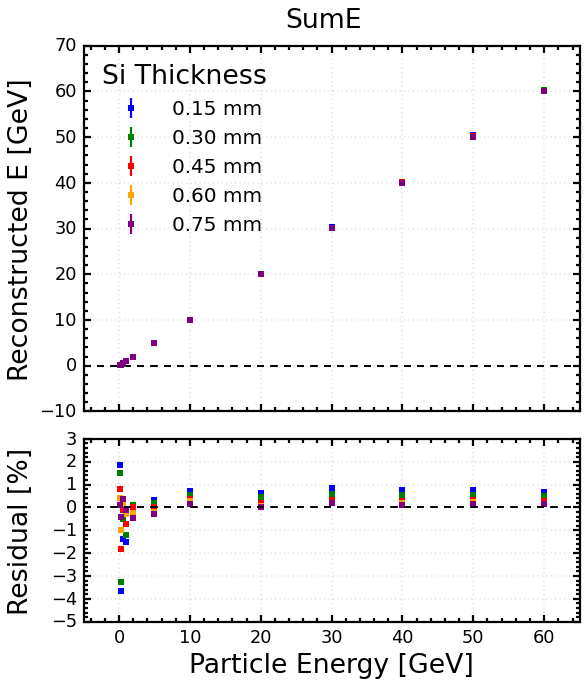

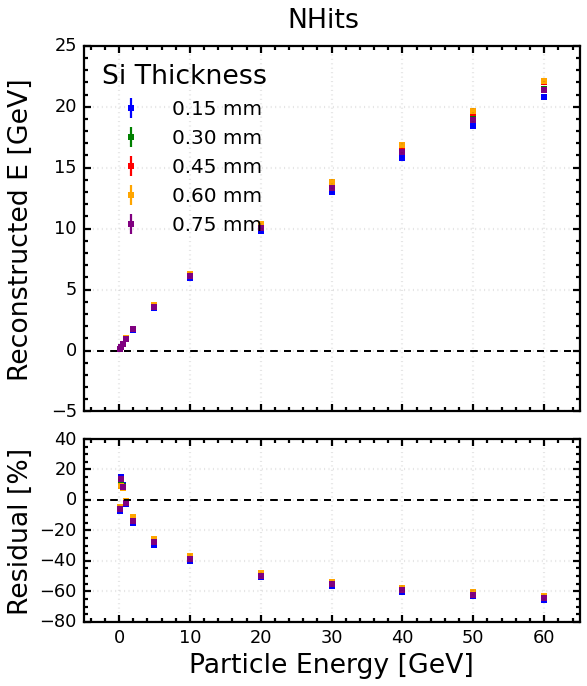

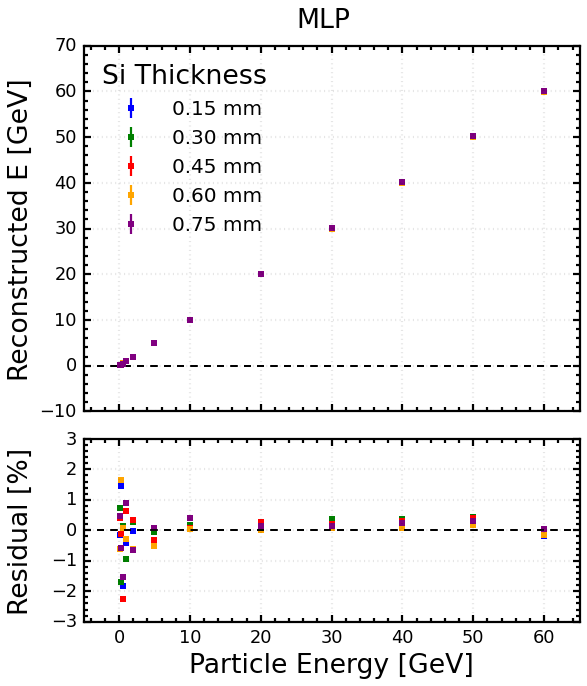

In [5]:

# Linearity and Resolution
def linear_func(x, a, b):
    return a * x + b

def fitAndResidualRatio(x, y, fit_range=(0,30)):
    """Linear fit and return coefficients, fit values, and relative residuals."""
    a0 = (y[-1] - y[0]) / (x[-1] - x[0])
    b0 = y[0]
    p0 = [a0, b0]
    upper_bound = [5*a0, np.inf]
    lower_bound = [0, -np.inf]  # Ensure slope is non-negative
    mask = (x >= fit_range[0]) & (x <= fit_range[1])
    coeffs, cov = curve_fit(linear_func, x[mask], y[mask], p0=p0, bounds=(lower_bound, upper_bound),sigma=x[mask], absolute_sigma=True)
    fitVals = linear_func(x, *coeffs)
    residualRatio = (y - fitVals) / fitVals
    return coeffs, fitVals, residualRatio

for config_idx, config in enumerate(Config):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(figSize[0], figSize[1]*1.6),
                                   sharex=True, gridspec_kw={'height_ratios':[1, 0.5], 'hspace':0.1})

    for ax in [ax1, ax2]:
        ax.yaxis.set_label_coords(-0.1, 0.5)  # x in axes coords, unify manually
    for Si_idx, Si_thickness in enumerate(Si):
        x = particleEnergy[Si_idx][config_idx]
        y = peakGamma[Si_idx][config_idx]
        y_err = peakGammaErr[Si_idx][config_idx]

        # Calib
        fit_range = (0, 2) if config == "NHits" else (0, 60)
        coeff, fitVals, residual = fitAndResidualRatio(x, y, fit_range=fit_range)
        y_calib = (y - coeff[1]) / coeff[0]
        y_err = y_err / coeff[0]
        #resGamma[cell_idx][config_idx] = (resGamma[cell_idx][config_idx] * y / coeff[0]) / y_calib
        coeff, fitVals, residual = fitAndResidualRatio(x, y_calib, fit_range=fit_range)
        residual = (y_calib - x) / x
        ax1.errorbar(x, y_calib, yerr=y_err, fmt='s', capsize=4,
                     color=colors[Si_idx], label=fr"{Si_thickness:.2f} mm")
        ax1.set_ylabel("Reconstructed E [GeV]")
        ax1.axhline(0, color='black', lw=axhline_lr, linestyle='--')
        ax1.set_xlim(-5, 65)
        ax1.legend(loc='upper left', fontsize=18, title="Si Thickness", title_fontsize=24)

        # Residual plot
        ax2.plot(x, residual*100, 's', color=colors[Si_idx])
        ax2.axhline(0, color='black', lw=axhline_lr, linestyle='--')
        ax2.set_xlabel(r"Particle Energy [GeV]")
        ax2.set_ylabel("Residual [%]")

    fig.suptitle(f"{Legend[config_idx]}", fontsize=24, y=0.95)
    plt.savefig(os.path.join(plot_dir, f"Linearity_{plot_conf}_{Legend[config_idx]}.pdf"), dpi=300, bbox_inches='tight')
    plt.show()
    



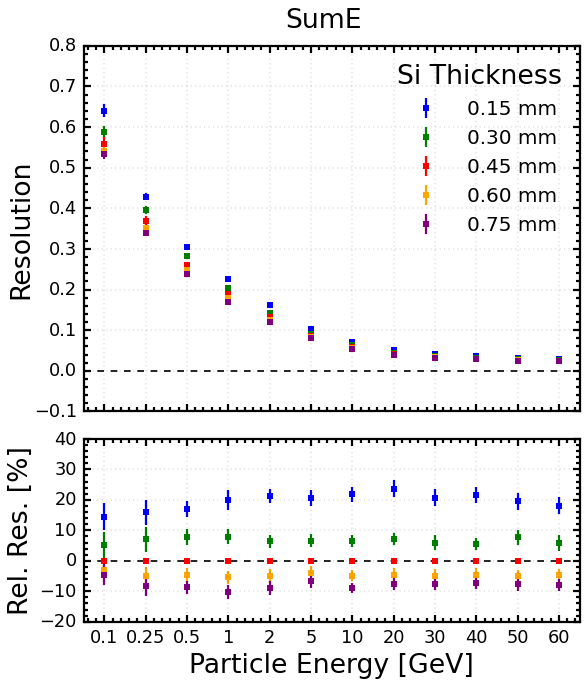

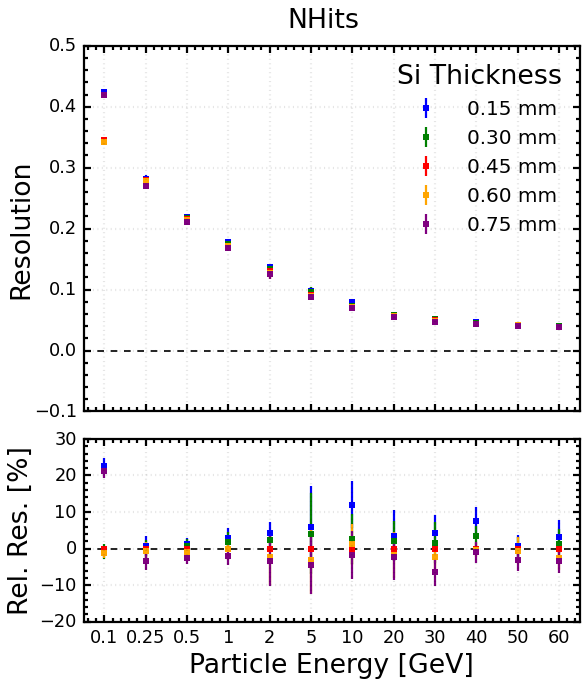

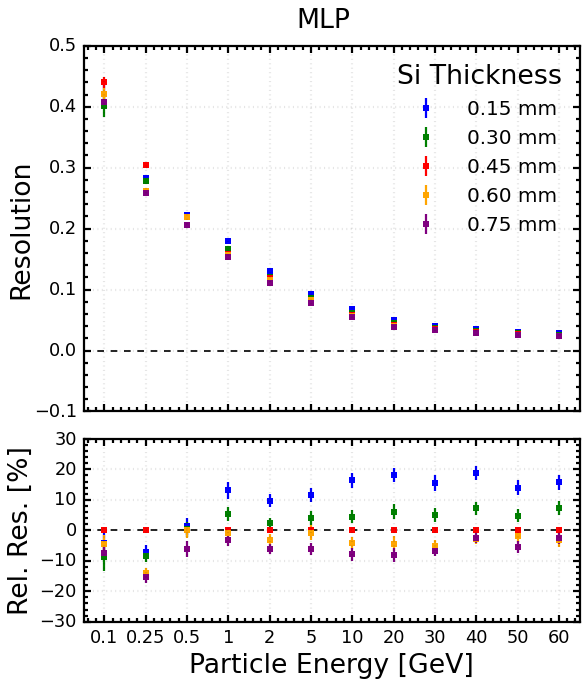

In [6]:
MarkerSize = 10
for i_c, config in enumerate(Config):
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(figSize[0], figSize[1]*1.6),
        sharex=True, gridspec_kw={'height_ratios': [1, 0.5], 'hspace': 0.1}
    )

    for ax in [ax1, ax2]:
        ax.yaxis.set_label_coords(-0.1, 0.5)  # x in axes coords, unify manually
    ref_idx = 2
    y_ref = np.array(resGamma[ref_idx][i_c])
    y_ref_err = np.array(resGammaErr[ref_idx][i_c])

    # -----------------------------
    # 1. 用点索引作为横坐标（均匀）
    # -----------------------------
    E_ref = np.array(particleEnergy[0][i_c])   # 用一个 cell 的能量作为 tick
    num_points = len(E_ref)
    x_idx = np.arange(num_points)              # 均匀点位置

    # -----------------------------
    # 2. 主图绘制
    # -----------------------------
    for Si_idx, Si_thickness in enumerate(Si):
        y_vals = np.array(resGamma[Si_idx][i_c])
        y_errs = np.array(resGammaErr[Si_idx][i_c])
        ax1.errorbar(
            x_idx, y_vals, yerr=y_errs,
            fmt='s', capsize=4,
            label=fr"{Si_thickness:.2f} mm",
            color=colors[Si_idx]
        )

        # -----------------------------
        # 3. Residual
        # -----------------------------
        if Si_idx == ref_idx:
            ax2.errorbar(
                x_idx, np.zeros_like(y_vals), yerr=y_errs / y_ref,
                fmt='s', capsize=4, label=fr"{Si_thickness:.2f} mm (ref)",
                color=colors[Si_idx]
            )
        else:
            u = y_vals / y_ref
            residual = u - 1
            residual_err = u * np.sqrt((y_errs / y_vals)**2 + (y_ref_err / y_ref)**2)

            ax2.errorbar(
                x_idx, residual * 100, yerr=residual_err * 100,
                fmt='s', capsize=4, label=fr"{Si_thickness:.2f} mm / ref",
                color=colors[Si_idx]
            )

    # -----------------------------
    # 4. X轴刻度按 E（GeV）显示
    # -----------------------------
    ax1.set_xticks(x_idx)  
    ax1.set_xticklabels([clean_number(e) for e in E_ref])  # 显示能量

    # Y/X label
    ax1.set_ylabel("Resolution")
    ax1.axhline(0, color='black', lw=axhline_lr, linestyle='--')
    ax1.set_xlim(-0.5, num_points - 0.5)
    ax1.legend(loc='upper right', fontsize=18, title="Si Thickness", title_fontsize=24)

    ax2.axhline(0, color='black', lw=axhline_lr, linestyle='--')
    ax2.set_xlabel("Particle Energy [GeV]")   # 主轴显示 E
    ax2.set_ylabel("Rel. Res. [%]")

    fig.suptitle(f"{Legend[i_c]}", fontsize=24, y=0.95)
    plt.savefig(os.path.join(plot_dir, f"Resolution_{plot_conf}_{Legend[i_c]}.pdf"), dpi=300, bbox_inches='tight')
    plt.show()
